<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

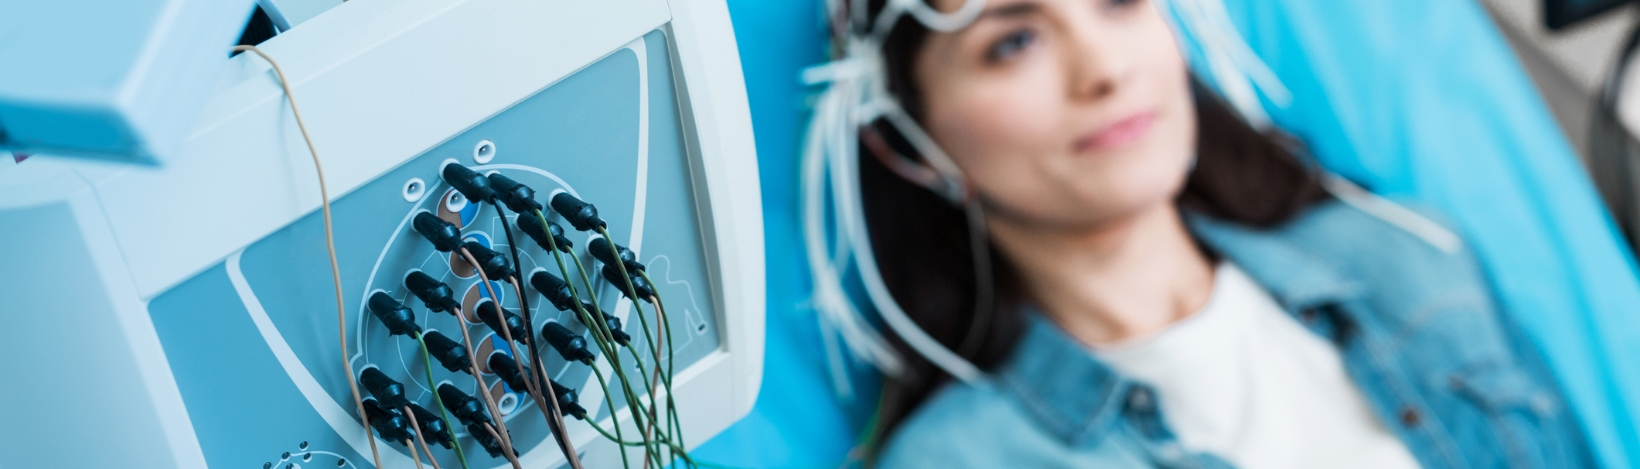

No material do Classroom desta aula, você encontrará um arquivo denominado “Dados.mat” contendo um registro de EEG (Canal Fp-Cz) obtido durante um exame de polissonografia. O arquivo contém 1179 trechos, de 30 segundos cada, armazenados na variável “SINAL” (trechos x tempo). Os trechos são amostrados a 100Hz. No mesmo arquivo você encontrará também um vetor “ESTAGIOS” (trechos x 1) contendo a classificação de cada trecho em estágios de sono (0 = vigília, 1 = estágio 1, 2 = estágio 2, 3 = estágio 3, 4 = estágio 4, 5 = REM). Nesta atividade você deverá empregar o método “t2_extraicarac” disponível no github do curso para calcular as características estatísticas e espectrais vistas durante esta aula (as características empregadas estão definidas nosslides da aula, disponível no classroom). O objetivo desta tarefa é entender como se extraem características comuns de sinais biomédicos e experimentar a complexidade de se trabalhar com espaços multidimensionais, algo que é corriqueiro no projeto de sistemas automatizados para apoio ao diagnóstico. Para atingir estes objetivos, siga os itens descritos a seguir.

In [ ]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
import seaborn as sns

In [ ]:
# leitura e tratamento dos dados
signal = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-2/Dados.mat")['SINAL']
stages = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-2/Dados.mat")['ESTAGIOS']

# definindo a frequencia
freq = 100

In [ ]:
# print do comprimento de cada estágio
print(f"Vigília: {len(stages[stages==0])}")
print(f"Estagio 1: {len(stages[stages==1])}")
print(f"Estagio 2: {len(stages[stages==2])}")
print(f"Estagio 3: {len(stages[stages==3])}")
print(f"Estagio 4: {len(stages[stages==4])}")
print(f"REM: {len(stages[stages==5])}")

Vigília: 480
Estagio 1: 56
Estagio 2: 407
Estagio 3: 35
Estagio 4: 99
REM: 102


In [ ]:
# separando as variaveis
vigilia = signal[0:480]
stage_1 = signal[481:536]
stage_2 = signal[537:943]
stage_3 = signal[944:978]
stage_4 = signal[979:1077]
rem = signal[1078:1179]

Neste caso, os estágios estão ordenados, mas por padrão e boas práticas, sempre utilizar o comando:



```
# features_general, names_general = t2_extraicarac(signal,freq,bandas,method='fft',nwelch=5)
vigilia = features_general[np.where(stages[0,:]==0)[0]]
```



**A)** Leia a função *t2_extraicarac* disponível no arquivo *main.py* do github do curso e garanta que você compreende o que ela faz *(observe os slides da aula, pesquise a respeito dos métodos empregados ou tire dúvidas com o professor ou a tutora, mas não empregue esta função sem compreendê-la)*.

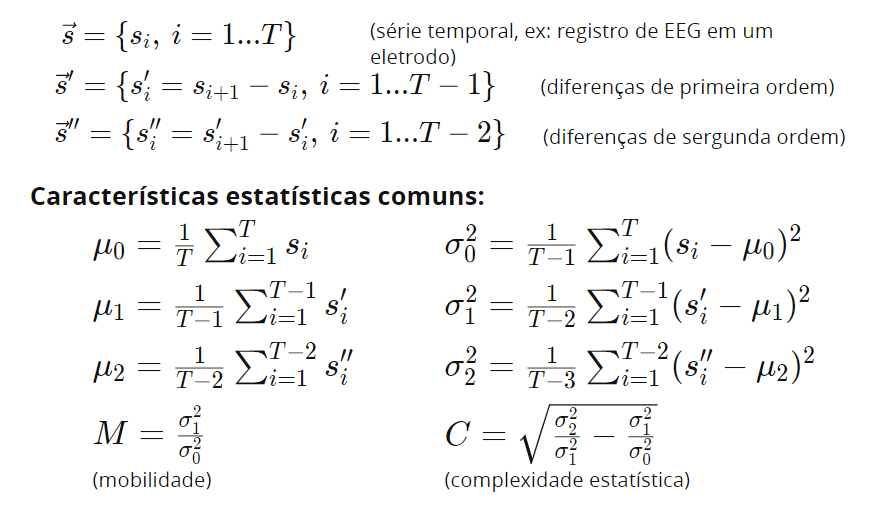

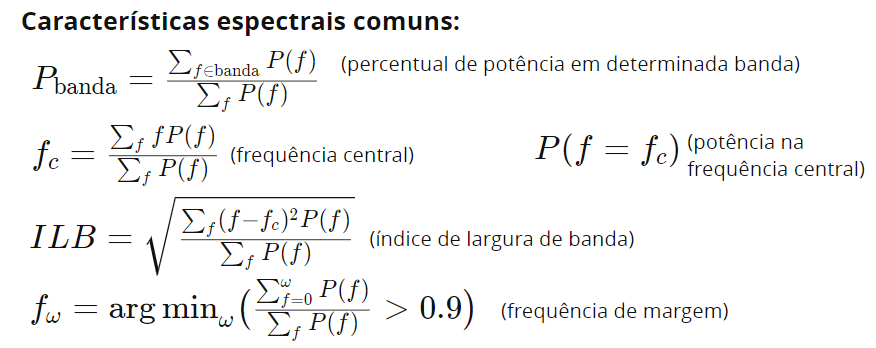


A função abaixo é usada para extrair características estatísticas e espectrais de um conjunto de sinais de mesma dimensão temporal. Vou focar em explicar duas características estatísticas e as espectrais.

- A mobilidade é como se fosse a velocidade que o sinal varia. Enquanto a variância analisa a variação na amplitude, a mobilidade já analisa o quão rápido o sinal variou.
- A complexidade é a primeira derivada da velocidade, ou seja, se durante a variação o sinal variou de forma constante ou não. Isso nos dá a ideia do quão imprevisível é o sinal.
- A frequência central, quando o sinal é observado no domínio da frequência, é a média ponderada das frequências no espectro. Isso significa que ela pode variar a sua posição caso o sinal seja muito lento ou muito rápido, pois a posição ficará sujeita a essas variações também.
- A potência na frequência central calcula então a potência que o sinal tem, dada a frequência central do sinal.
- Frequência de margem calcula a frequência de margem do espectro, que é a frequência onde a área acumulada do espectro atinge 90%. Na função matemática é o menor argumento (menor valor) da parte que está acima de 90%.

In [ ]:
# definindo a funcao de extracao de caracteristicas
def t2_extraicarac(sin,freq,bandas,method='fft',nwelch=5):
  """
  Extrai características estatísticas e espectrais de um conjunto de sinais de mesma dimensão temporal.
  Inputs:
    - sin = numpy array (num de sinais x tempo)
    - freq = frequencia de amostragem dos sinais (Hz)
    - bandas = dicionario com a informação das bandas de frequencia a serem extraídas.
               Formato:{'nome da banda (string)':[freqinicial, freqfinal]}
               Exemplo:
               bandas={'delta 1':[0.5,2.5],'delta 2':[2.5,4],'teta 1':[4,6],'teta 2':[6,8], 'alfa':[8,12],'beta':[12,20],'gama':[20,45]}
    - method = 'fft' or 'welch' (se welch, "nwelch" é o numero de trechos no qual o sinal é dividido)
  Output:
    - retorna um array de trechos x características e uma lista com os nomes das
  caracteristicas correspondentes ao array
  """

  (S,X)=np.shape(sin) #S = numero de sinais sinais; X = tamanho dos sinais no tempo
  nc=8+len(bandas) #numero de caracteristicas que serao extraidas
  car=np.zeros((S,nc)) #matriz das caracteristicas
  nomesc=[None]*nc
  for s in range(S):
    #média
     car[s,0]=np.mean(sin[s,:])
     nomesc[0]='media'

    #variancia
     var0=np.var(sin[s,:],ddof=1)
     car[s,1]=var0
     nomesc[1]='variancia'

    #mobilidade
     x1=np.diff(sin[s,:])
     var1=np.var(x1,ddof=1)
     mob=var1/var0
     car[s,2]=mob
     nomesc[2]='mobilidade'

    #complexidade estatística
     x2=np.diff(x1)
     var2=np.var(x2,ddof=1)
     ce=(var2/var1-var1/var0)**(1/2)
     car[s,3]=ce
     nomesc[3]='complexidade'

    ##calculando o espectro:
     if method=='fft':
       yf = np.abs(fft.rfft(sin[s,:]-car[s,0]))**2
       yf=yf/X
       yf=yf[0:int(np.floor(X/2)+1)]
       xf = np.linspace(0.0, 1.0/(2.0/freq), len(yf))
     elif method=='welch':
       xf,yf = welch(sin[s,:]-car[s,0],freq,nperseg=X//nwelch)
     Yf=yf/np.sum(yf)

    #frequência central do espectro
     car[s,4]=np.sum(xf*Yf)
     nomesc[4]='f-central'

    #potencia na frequencia central
     ifc=np.abs(xf-car[s,4])==np.min(np.abs(xf-car[s,4]))
     car[s,5]=yf[ifc]
     nomesc[5]='P na fc'

    #largura de banda do espectro
     car[s,6]=np.sqrt(np.sum(((xf-car[s,4])**2)*Yf))
     nomesc[6]='l-banda'

    #frequência de margem do espectro
     sw=np.cumsum(Yf)
     f=np.max(np.where(sw<=0.9)[0])
     car[s,7]=xf[f]
     nomesc[7]='f-margem'

    #potências espectrais normalizadas nas seguintes bandas:
    #delta 1 (0.5 a 2.5Hz)
     for ib, b in enumerate(bandas):
        car[s,8+ib]=sum(Yf[((xf>=bandas[b][0]) & (xf<=bandas[b][1]))])
        nomesc[8+ib]='%'+b

  return (car,nomesc)

Use esta função para calcular as características de cada um dos trechos do EEG do exame de polissonografia. Para extrair as potências espectrais normalizadas, empregue as seguintes bandas de frequência que são típicas do EEG:

*   delta 1 (0.5 a 2.5Hz)
*   delta 2 (2.5 a 4 Hz)
*   theta 1 (4 a 6Hz)
*   theta 2 (6 8Hz)
*   alpha (8 a 12 Hz)
*   beta (12 a 20 Hz)
*   gama (20 a 45Hz)





In [ ]:
# selecionando as bandas de frequência
bandas = {
    "delta 1": [0.5,2.5],
    "delta 2": [2.5,4],
    "theta 1": [4,6],
    "theta 2": [6, 8],
    "alpha": [8, 12],
    "beta": [12, 20],
    "gama": [20, 45]
}

In [ ]:
# utilizando a funcao de extracao de caracteristicas
features_vigilia, names_vigilia = t2_extraicarac(vigilia,freq,bandas,method='fft',nwelch=5)
features_stage_1, names_stage_1 = t2_extraicarac(stage_1,freq,bandas,method='fft',nwelch=5)
features_stage_2, names_stage_2 = t2_extraicarac(stage_2,freq,bandas,method='fft',nwelch=5)
features_stage_3, names_stage_3 = t2_extraicarac(stage_3,freq,bandas,method='fft',nwelch=5)
features_stage_4, names_stage_4 = t2_extraicarac(stage_4,freq,bandas,method='fft',nwelch=5)
features_rem, names_rem = t2_extraicarac(rem,freq,bandas,method='fft',nwelch=5)

Dado um sinal no domínio da frequência, a frequência central é a frequência do meio. Ela pode variar se o sinal fro mui lento ou muito rápido, pois neste caso, em um gráfico, ela ficaria concentrada mais para o lado que está mais rápido ou mais lento. O mesmo acontece para a potência na frequência central.

A mobilidade refere-se a quão rápido um sinal se move, se ele varia mais rapidamente ou menos rapidamente, diferentemente da veriância, que mede essa variação apenas pela amplitude do sinal. A complexidade, já envolve a segunda derivada da posição, ou seja, a aceleração, uma vez que o sinal pode se mover com uma velocidade constante ou não. É importante frisar que a ocmplexidade está relacionada ao quão variável é o sinal. Em outras palavras, o quão ele é imprevisível.

# Histogramas das características

**C)** Gere histogramas destas características para inspecioná-las individualmente *(alguns resultados ilustrativos estão nas páginas finais deste documento)*.

In [ ]:
features[0]

array([[1.29530160e+00, 3.59102976e+03, 2.58406887e-01, ...,
        1.41332129e-02, 2.14206236e-02, 5.84646408e-02],
       [1.27923811e+00, 2.77756220e+03, 5.02119834e-01, ...,
        2.13624045e-02, 3.55150900e-02, 1.20756615e-01],
       [1.76774600e+00, 3.18068452e+03, 7.74581251e-01, ...,
        3.29460702e-02, 5.32205679e-02, 1.90513388e-01],
       ...,
       [9.64476200e-01, 2.59822548e+00, 1.65565651e+00, ...,
        4.19348069e-02, 4.47690262e-02, 4.49790081e-01],
       [1.00866667e+00, 3.38580938e+00, 1.17337000e+00, ...,
        2.95808914e-02, 2.30490210e-02, 3.17729259e-01],
       [9.98285723e-01, 2.71663355e+00, 1.46575973e+00, ...,
        3.62558006e-02, 3.29869003e-02, 3.98226854e-01]])

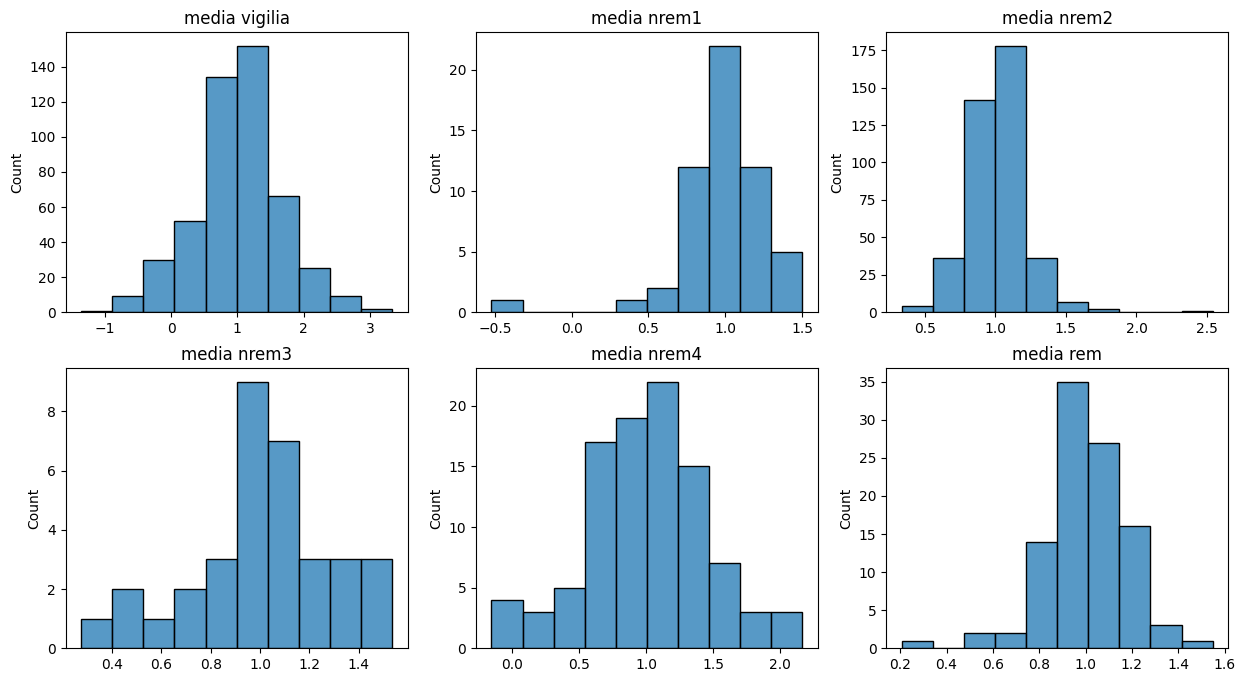

In [ ]:
# histograma das medias das caracteristicas
features = [features_vigilia,features_stage_1,features_stage_2,features_stage_3,features_stage_4,features_rem]
names_media = ['media vigilia','media nrem1','media nrem2','media nrem3','media nrem4','media rem']

plt.figure(figsize=(15,8))

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,0],bins=10)
  plt.title(names_media[index])

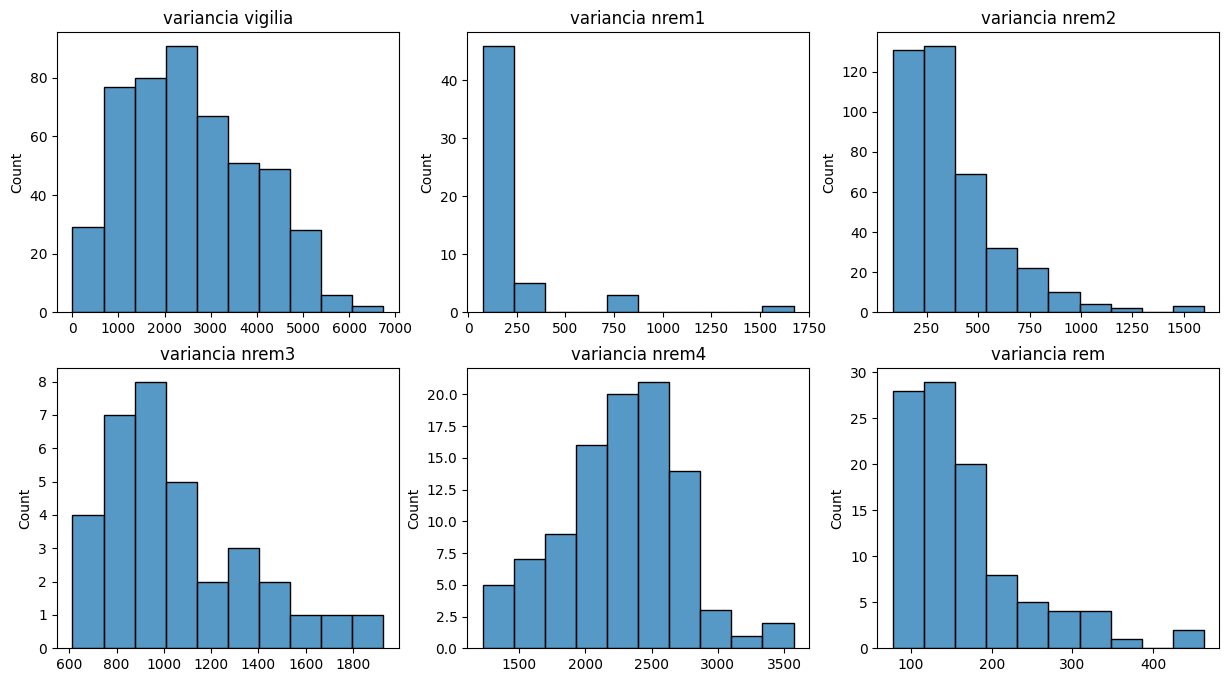

In [ ]:
#histograma das variâncias das características
plt.figure(figsize=(15,8))
names_var = ['variancia vigilia','variancia nrem1','variancia nrem2','variancia nrem3','variancia nrem4','variancia rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,1],bins=10)
  plt.title(names_var[index])

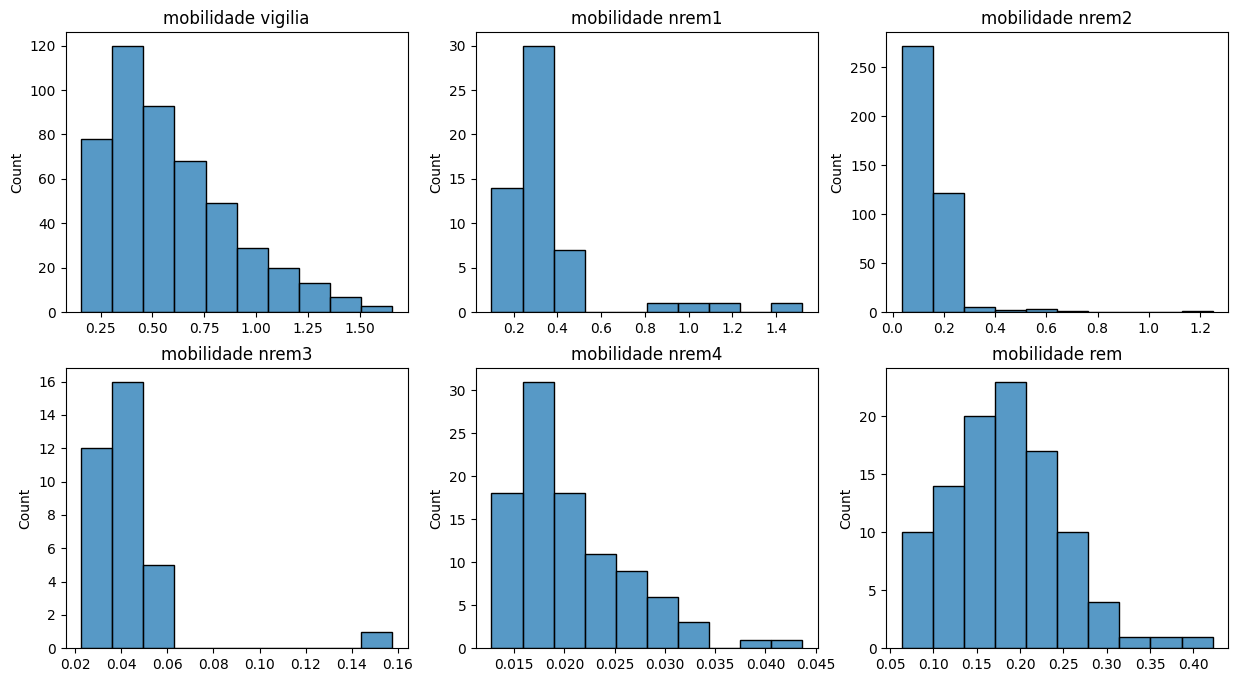

In [ ]:
# histograma da mobilidade
plt.figure(figsize=(15,8))
names_mob = ['mobilidade vigilia','mobilidade nrem1','mobilidade nrem2','mobilidade nrem3','mobilidade nrem4','mobilidade rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,2],bins=10)
  plt.title(names_mob[index])

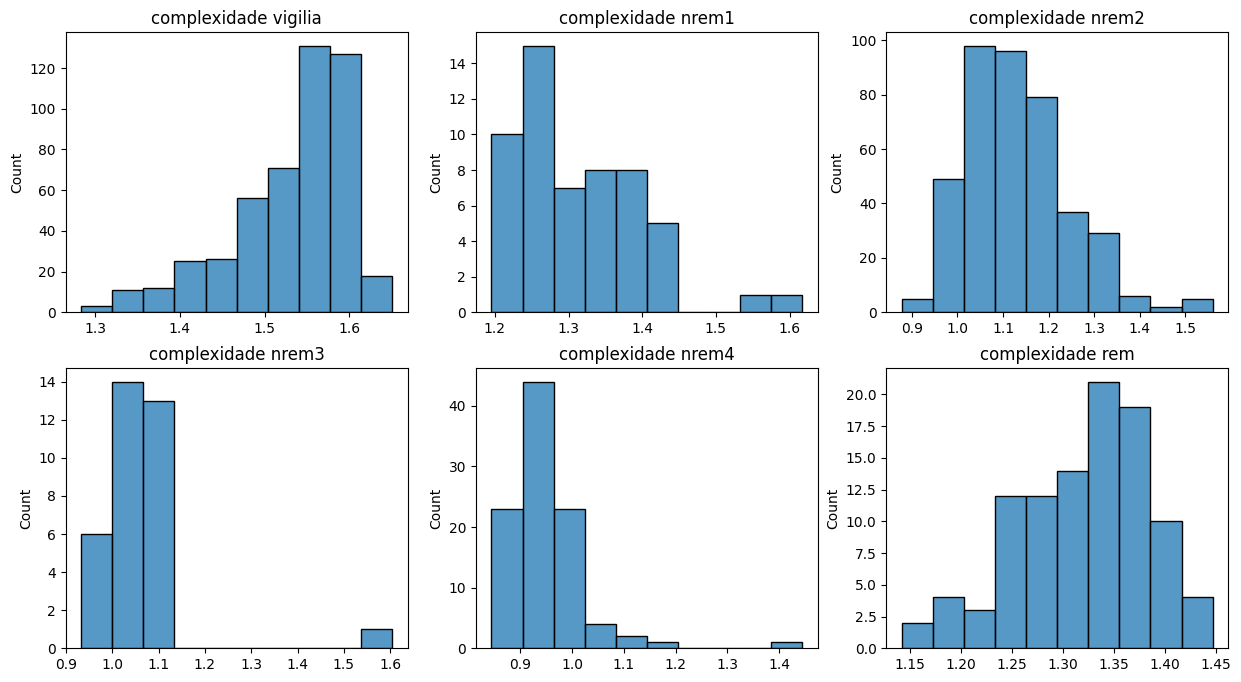

In [ ]:
# histograma da complexidade
plt.figure(figsize=(15,8))
names_comp = ['complexidade vigilia','complexidade nrem1','complexidade nrem2','complexidade nrem3','complexidade nrem4','complexidade rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,3],bins=10)
  plt.title(names_comp[index])

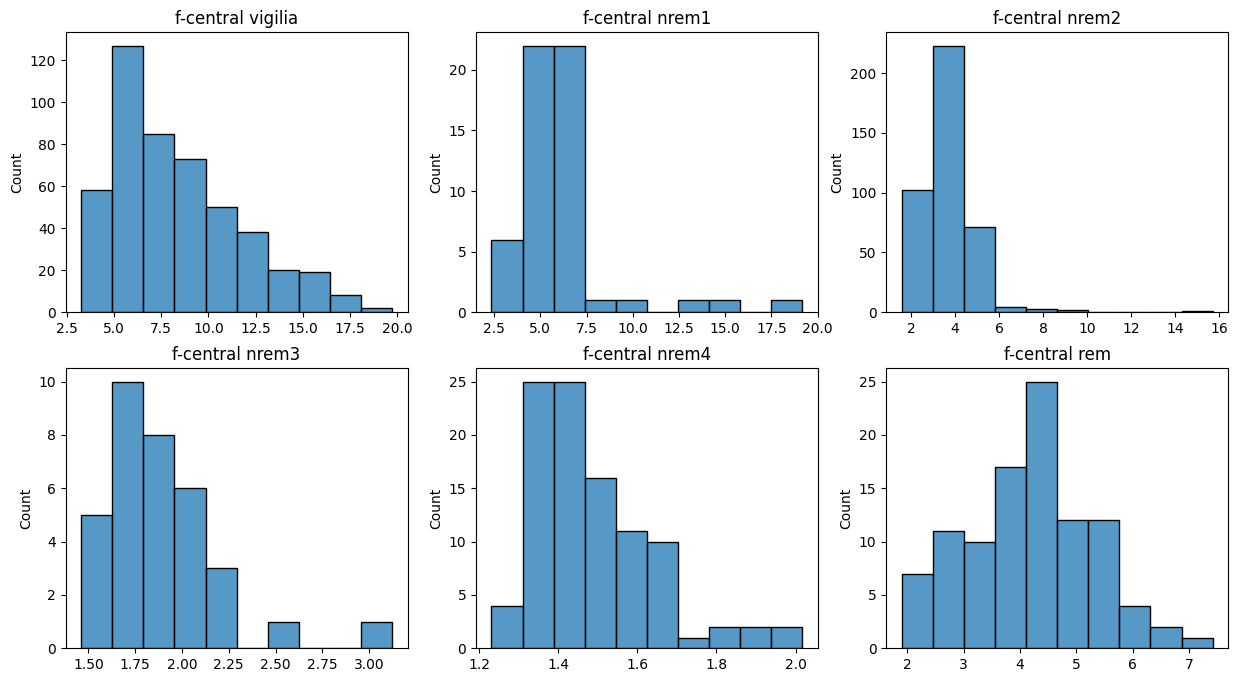

In [ ]:
# histograma da frequência central
plt.figure(figsize=(15,8))
names_fcentral = ['f-central vigilia','f-central nrem1','f-central nrem2','f-central nrem3','f-central nrem4','f-central rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,4],bins=10)
  plt.title(names_fcentral[index])

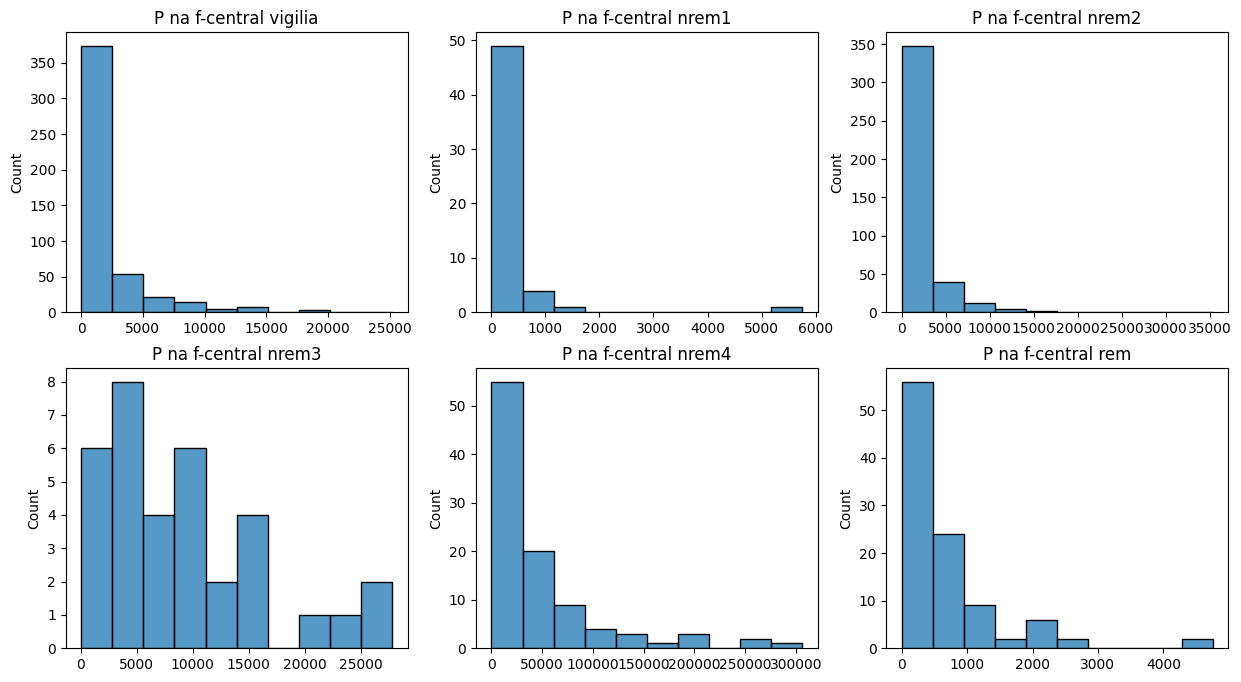

In [ ]:
# histograma da potência na frequência central
plt.figure(figsize=(15,8))
names_p_fcentral = ['P na f-central vigilia','P na f-central nrem1','P na f-central nrem2',
                  'P na f-central nrem3','P na f-central nrem4','P na f-central rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,5],bins=10)
  plt.title(names_p_fcentral[index])

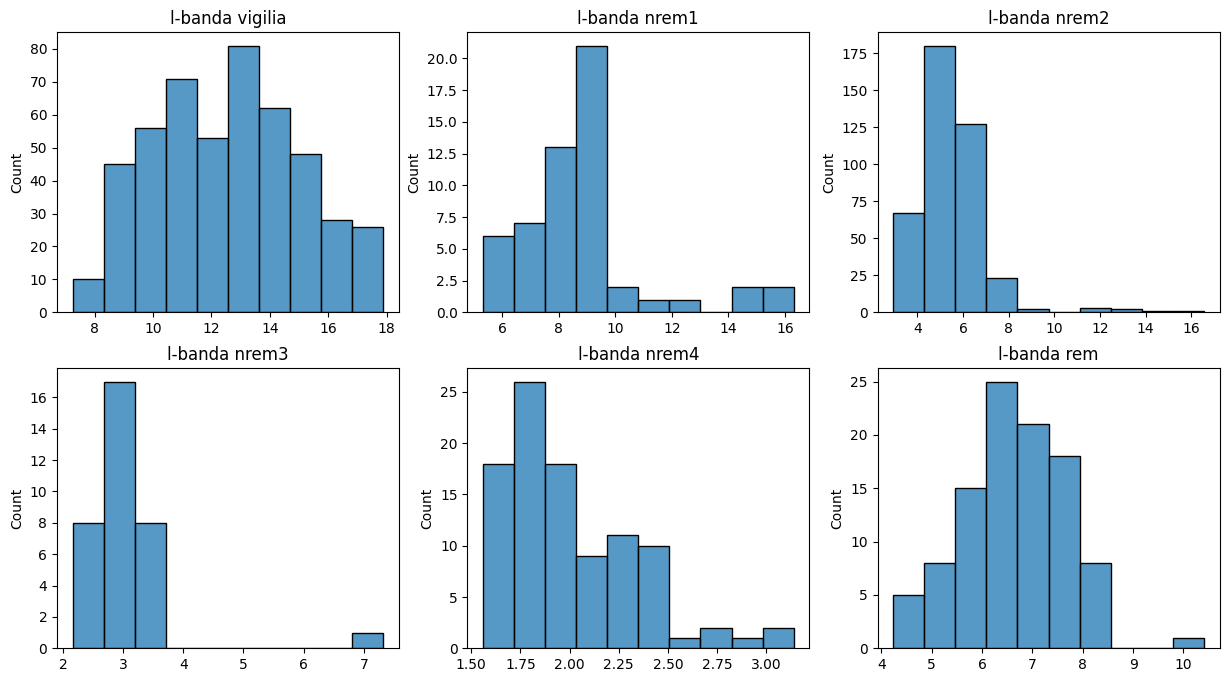

In [ ]:
# histograma da l-banda
plt.figure(figsize=(15,8))
names_l_banda = ['l-banda vigilia','l-banda nrem1','l-banda nrem2',
                  'l-banda nrem3','l-banda nrem4','l-banda rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,6],bins=10)
  plt.title(names_l_banda[index])

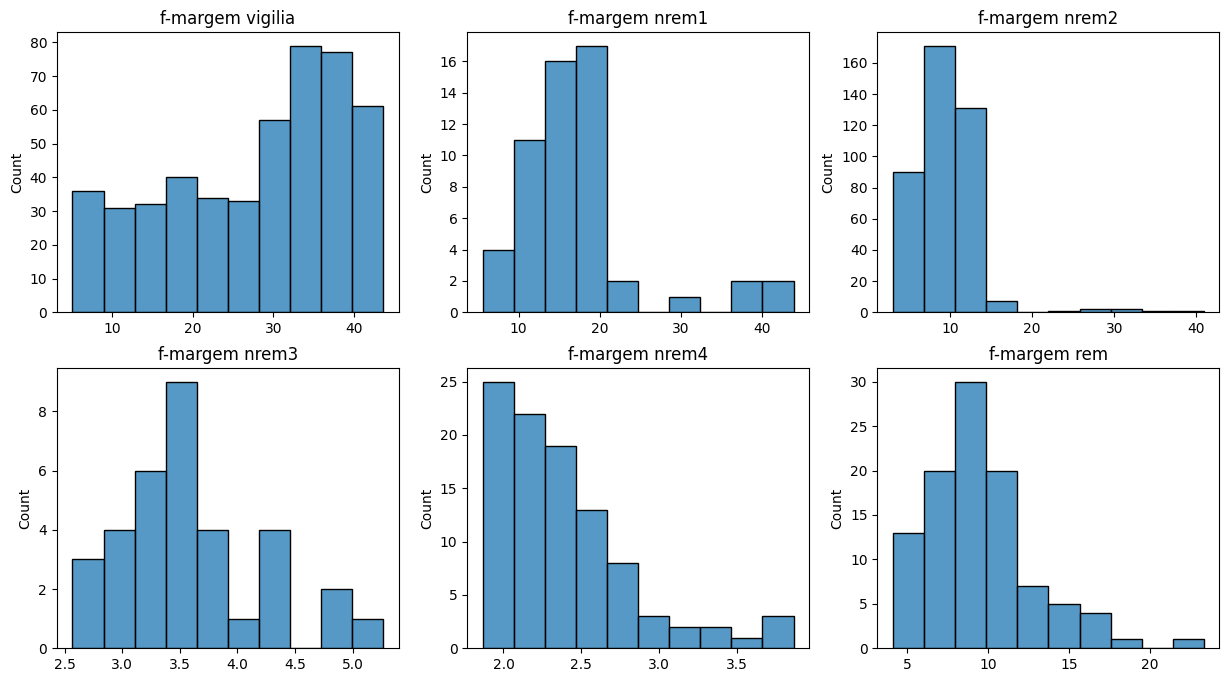

In [ ]:
# histograma da f-margem
plt.figure(figsize=(15,8))
names_f_margem = ['f-margem vigilia','f-margem nrem1','f-margem nrem2',
                  'f-margem nrem3','f-margem nrem4','f-margem rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,7],bins=10)
  plt.title(names_f_margem[index])

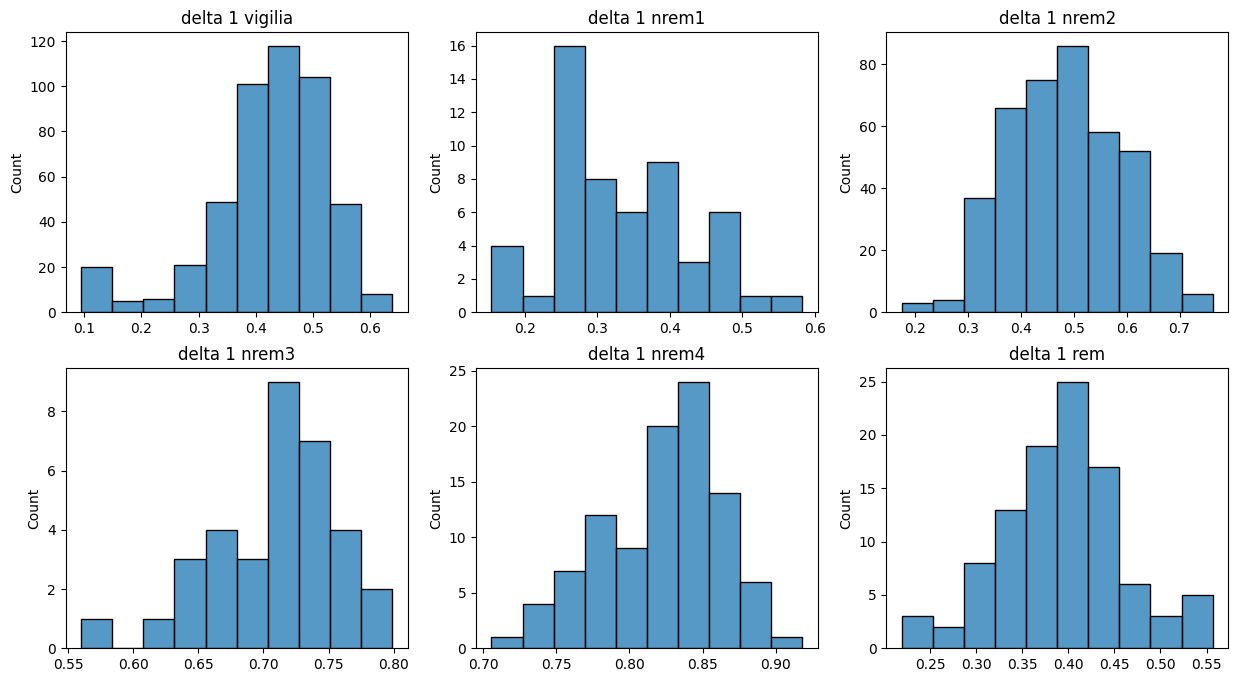

In [ ]:
# histograma da % delta 1
plt.figure(figsize=(15,8))
names_delta_1 = ['delta 1 vigilia','delta 1 nrem1','delta 1 nrem2',
                  'delta 1 nrem3','delta 1 nrem4','delta 1 rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,8],bins=10)
  plt.title(names_delta_1[index])

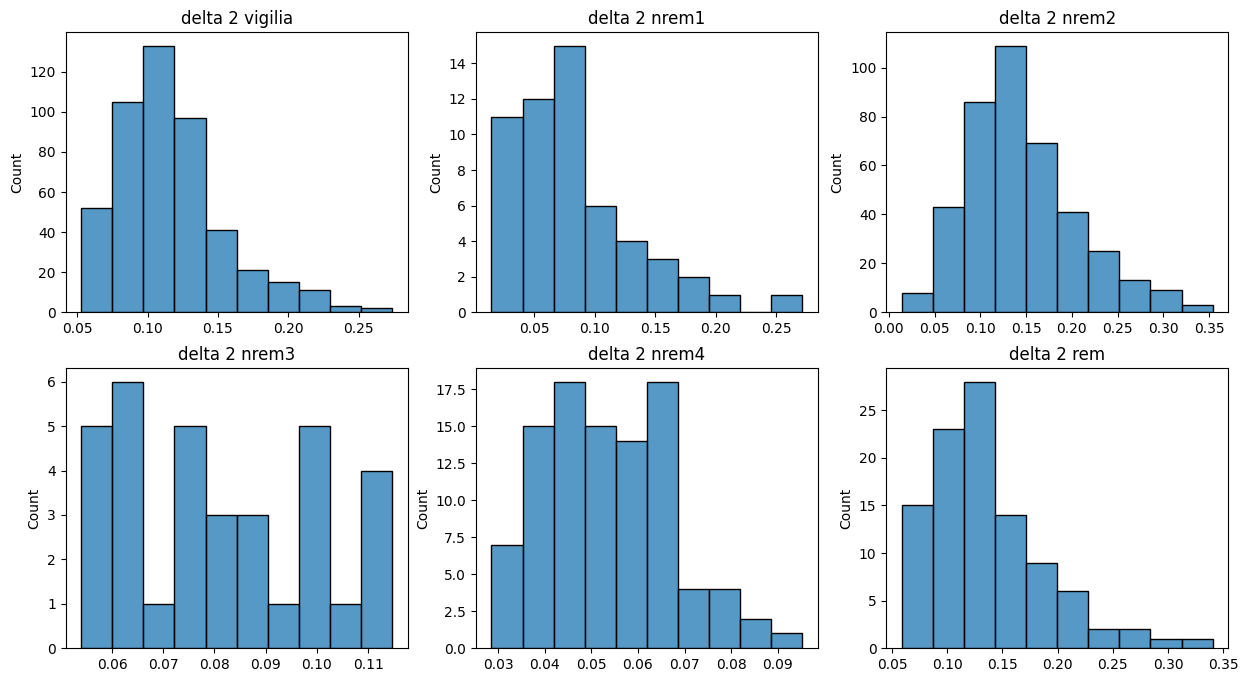

In [ ]:
# histograma da % delta 2
plt.figure(figsize=(15,8))
names_delta_2 = ['delta 2 vigilia','delta 2 nrem1','delta 2 nrem2',
                  'delta 2 nrem3','delta 2 nrem4','delta 2 rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,9],bins=10)
  plt.title(names_delta_2[index])

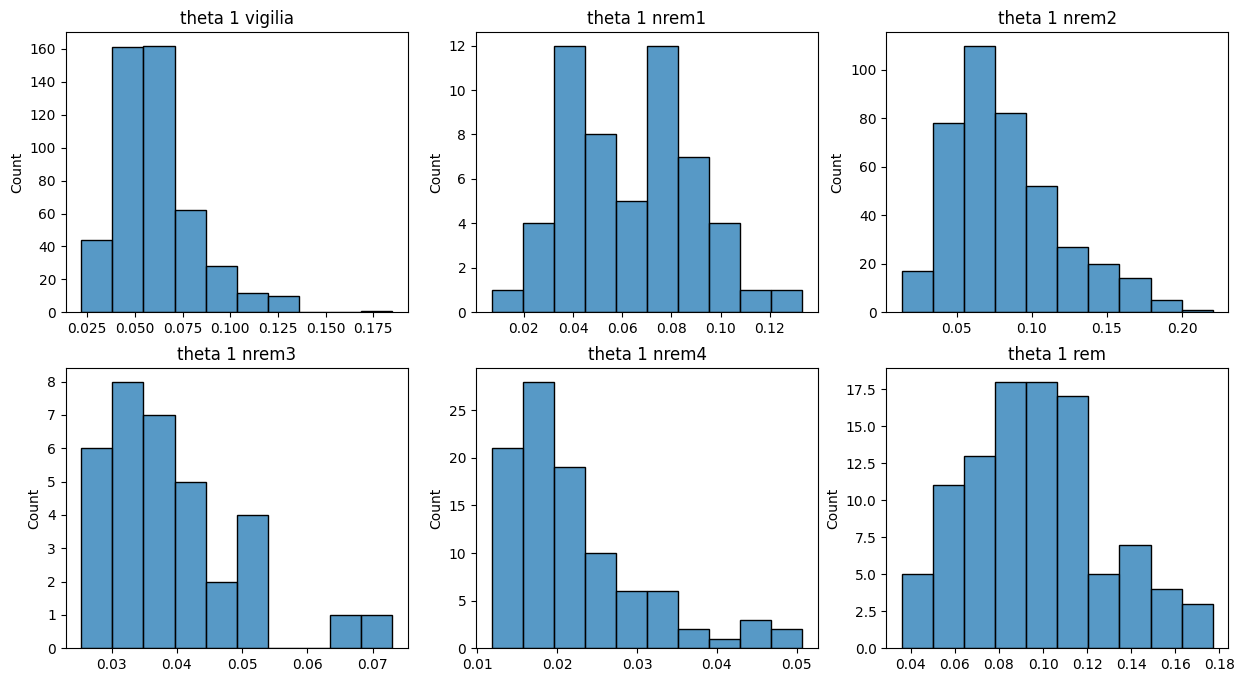

In [ ]:
# histograma da % theta 1
plt.figure(figsize=(15,8))
names_theta_1 = ['theta 1 vigilia','theta 1 nrem1','theta 1 nrem2',
                  'theta 1 nrem3','theta 1 nrem4','theta 1 rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,10],bins=10)
  plt.title(names_theta_1[index])

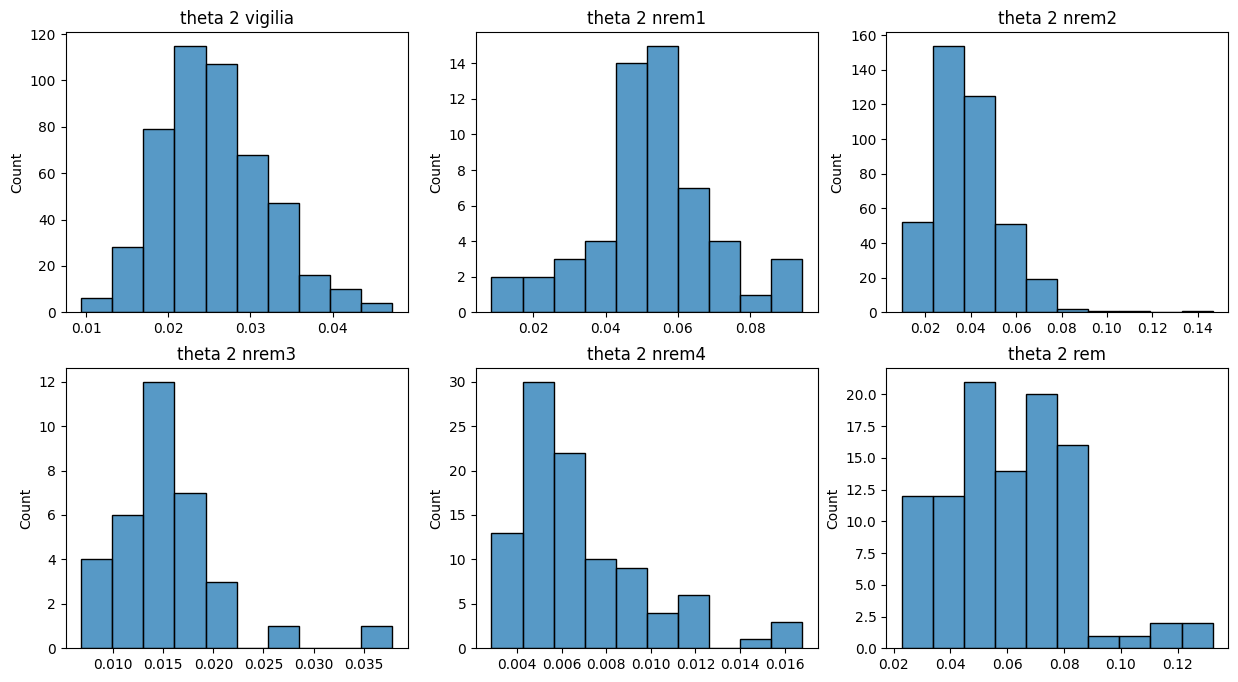

In [ ]:
# histograma da % theta 2
plt.figure(figsize=(15,8))
names_theta_2 = ['theta 2 vigilia','theta 2 nrem1','theta 2 nrem2',
                  'theta 2 nrem3','theta 2 nrem4','theta 2 rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,11],bins=10)
  plt.title(names_theta_2[index])

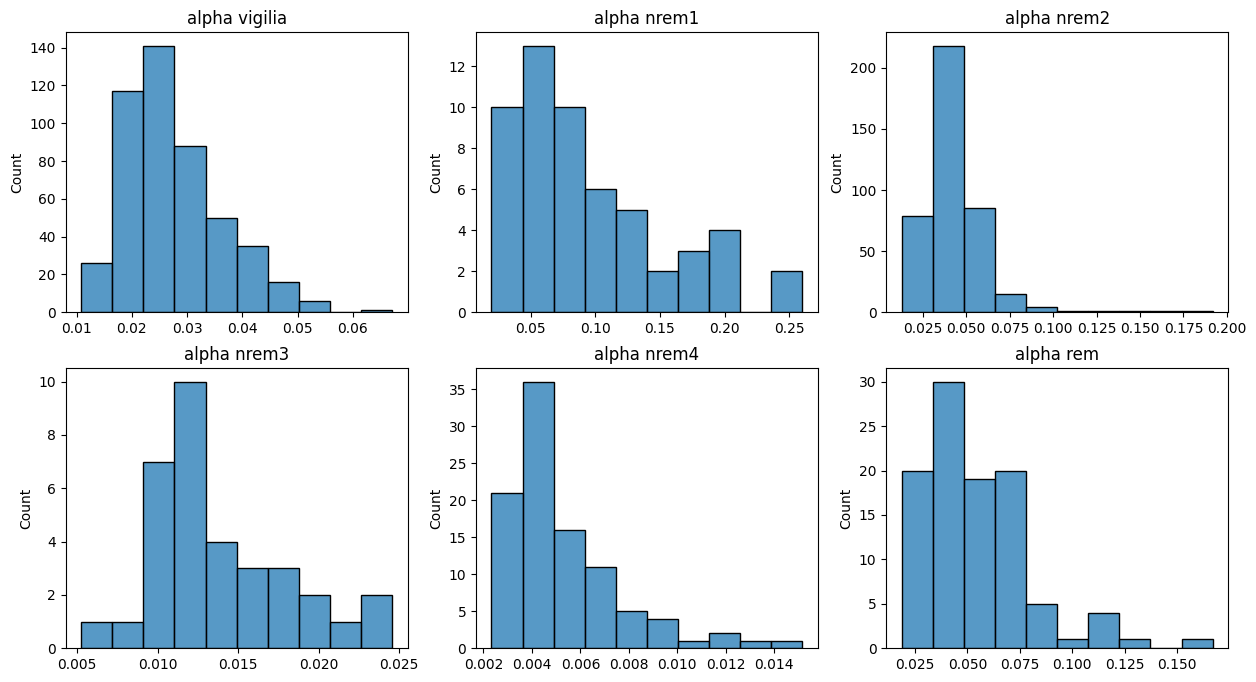

In [ ]:
# histograma da % alpha
plt.figure(figsize=(15,8))
names_alpha = ['alpha vigilia','alpha nrem1','alpha nrem2',
                  'alpha nrem3','alpha nrem4','alpha rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,12],bins=10)
  plt.title(names_alpha[index])

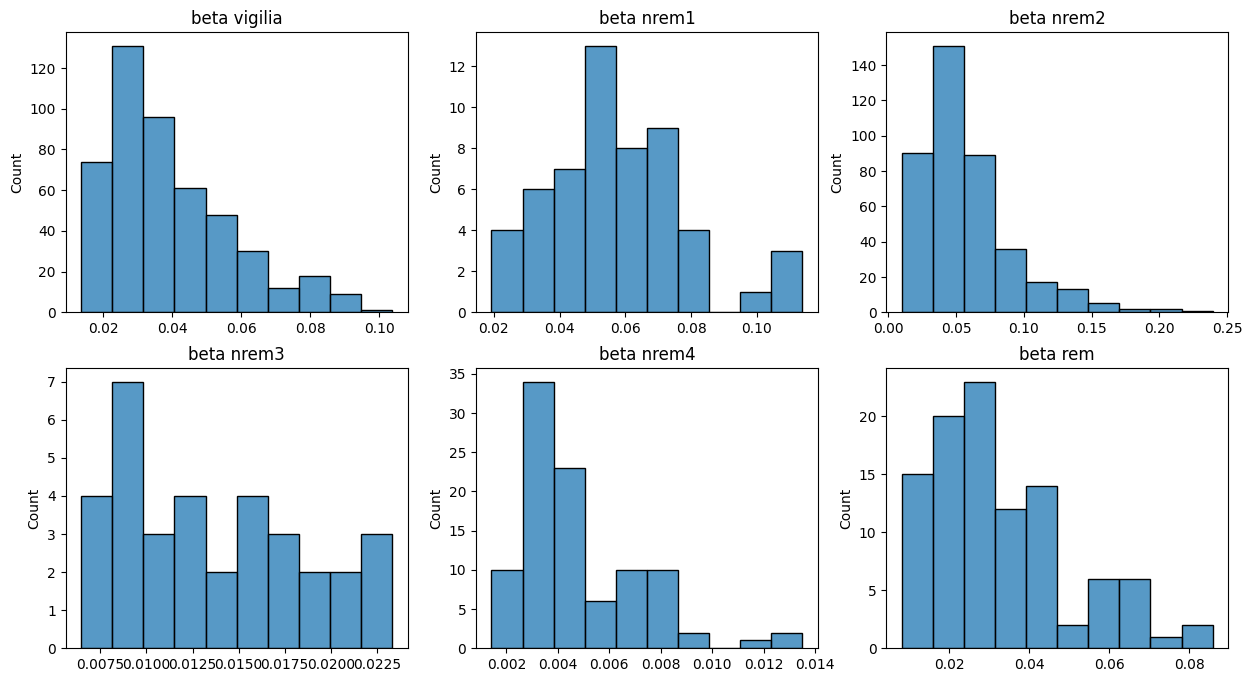

In [ ]:
# histograma da % beta
plt.figure(figsize=(15,8))
names_beta = ['beta vigilia','beta nrem1','beta nrem2',
                  'beta nrem3','beta nrem4','beta rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,13],bins=10)
  plt.title(names_beta[index])

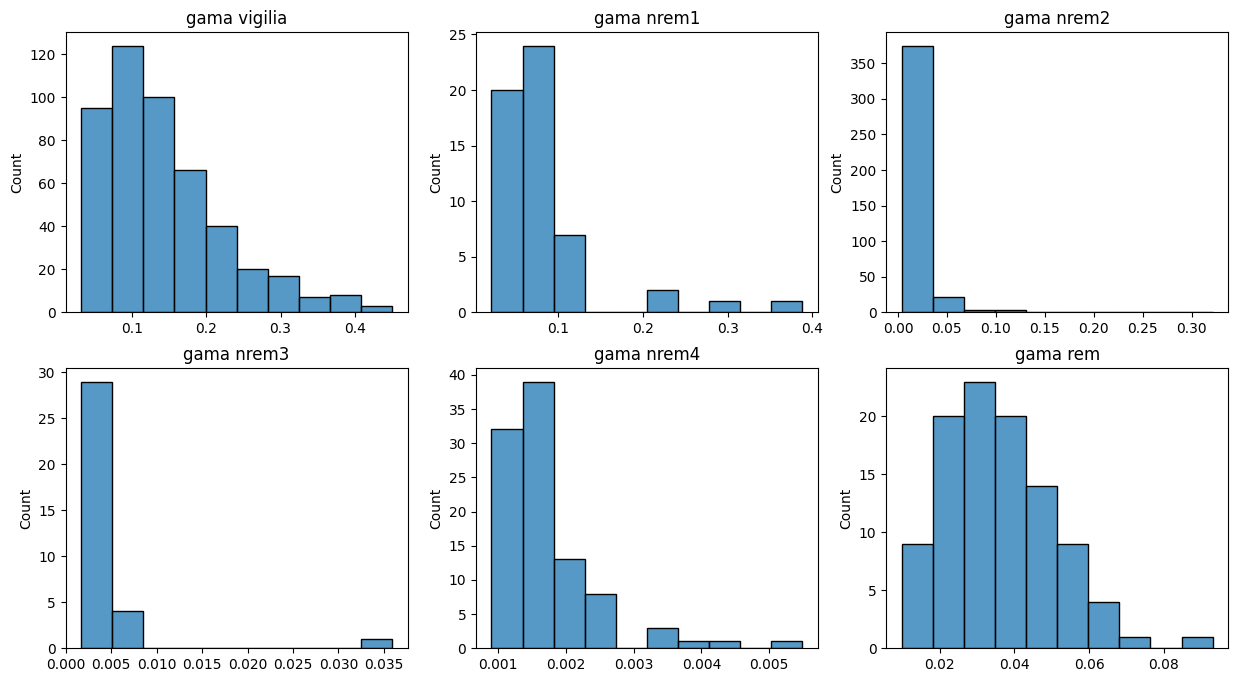

In [ ]:
# histograma da % alpha
plt.figure(figsize=(15,8))
names_gama = ['gama vigilia','gama nrem1','gama nrem2',
                  'gama nrem3','gama nrem4','gama rem']

for index in range(0,6):
  plt.subplot(2,3,index+1)
  sns.histplot(features[index][:,14],bins=10)
  plt.title(names_gama[index])

**D)** Agora construa espaços de características em duas dimensões, mostrando as classes com cores diferentes *(veja o exemplo na figura 1 a seguir)*. Você saberia identificar o melhor espaço para separar a vigília dos diferentes estágios de sono?

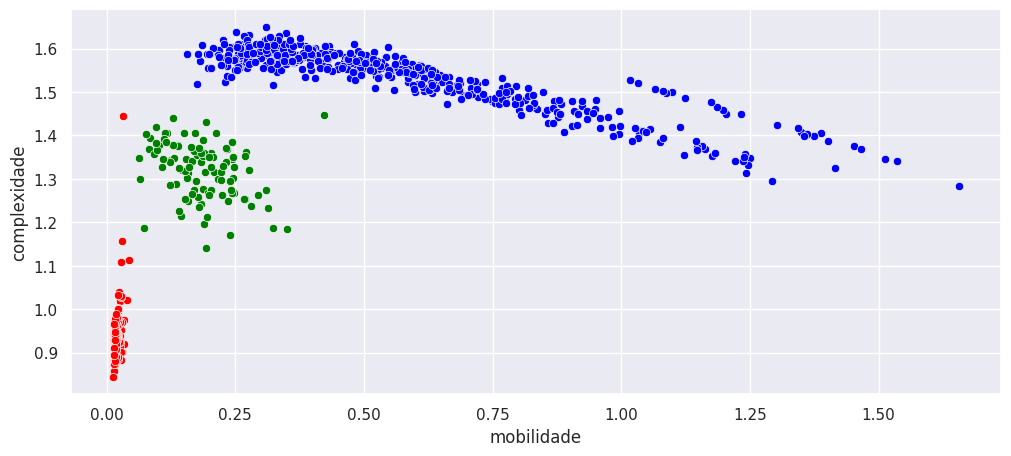

In [ ]:
# plot do espaço de características em duas dimensões
sns.set_theme()

plt.figure(figsize=(12,5))
plt.xlabel('mobilidade')
plt.ylabel('complexidade')

sns.scatterplot(y=features_vigilia[:,3],x=features_vigilia[:,2],color='blue',markers='O')
sns.scatterplot(y=features_stage_4[:,3],x=features_stage_4[:,2],color='red',markers='O')
sns.scatterplot(y=features_rem[:,3],x=features_rem[:,2],color='green',markers='O')

plt.show()

Com essas duas características (complexidade e mobilidade) é possível separar os trechos a olho nu, vistos que eles estão bem separados um do outro.

**E)** Inspecione as classes em espaços de características de três dimensões. Em particular, observe os valores para os estágios correspondentes à vigília, ao sono REM e ao sono não-REM de ondas lentas, estudando diversas combinações de características *(veja um exemplo na figura 2 a seguir)*. Novamente, você saberia identificar o melhor espaço para separar as classes?

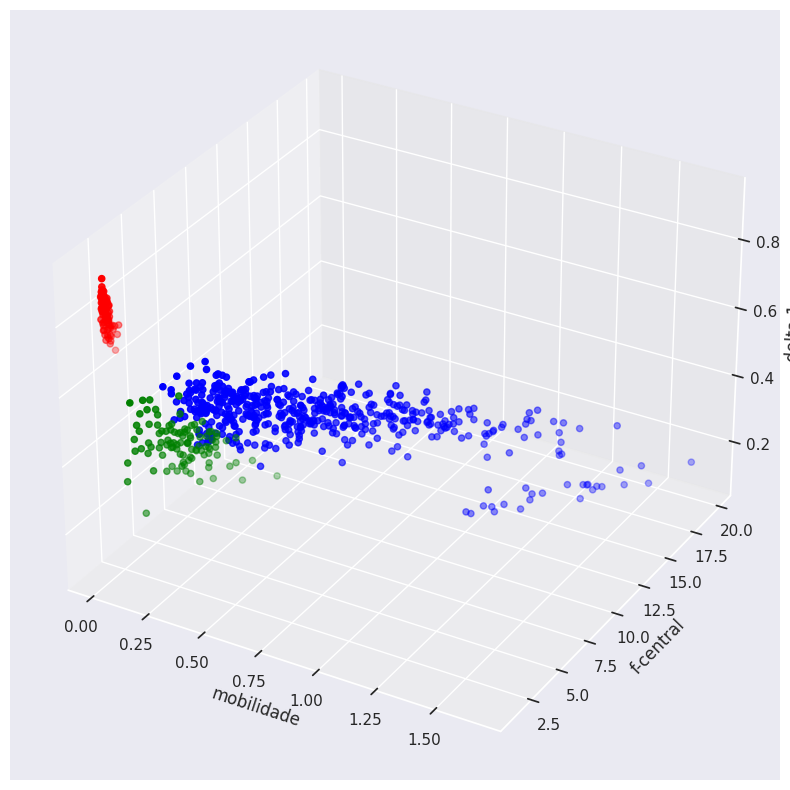

In [ ]:
# plotando as características em 3 dimensões para as caracterísitcas mobilidade, f-central e delta 1
plt.figure(figsize=(15,10))

# definindo os eixos da vigilia
x_vigilia = features_vigilia[:,2]
y_vigilia = features_vigilia[:,4]
z_vigilia = features_vigilia[:,8]

# definindo os eixos do nrem4
x_nrem4 = features_stage_4[:,2]
y_nrem4 = features_stage_4[:,4]
z_nrem4 = features_stage_4[:,8]

# definindo os eixos do rem
x_rem = features_rem[:,2]
y_rem = features_rem[:,4]
z_rem = features_rem[:,8]

# definindo os nome dos eixos
ax = plt.axes(projection ="3d")
ax.set_xlabel('mobilidade')
ax.set_ylabel('f-central')
ax.set_zlabel('delta 1')

ax.scatter(x_vigilia, y_vigilia, z_vigilia, color = "blue",marker='o')
ax.scatter(x_nrem4, y_nrem4, z_nrem4, color = "red",marker='o')
ax.scatter(x_rem, y_rem, z_rem, color = "green",marker='o')

Com três características, separar os trechos começa a se tornar uma tarefa mais complexa a olho nu. Inicialmente, o estágio nrem4 é o que mais se diferencia das outras classes. Contudo, as classes de vigília e REM estão próximas e em alguns pontos até juntos, fazendo com que não seja possível fazer uma distinção.

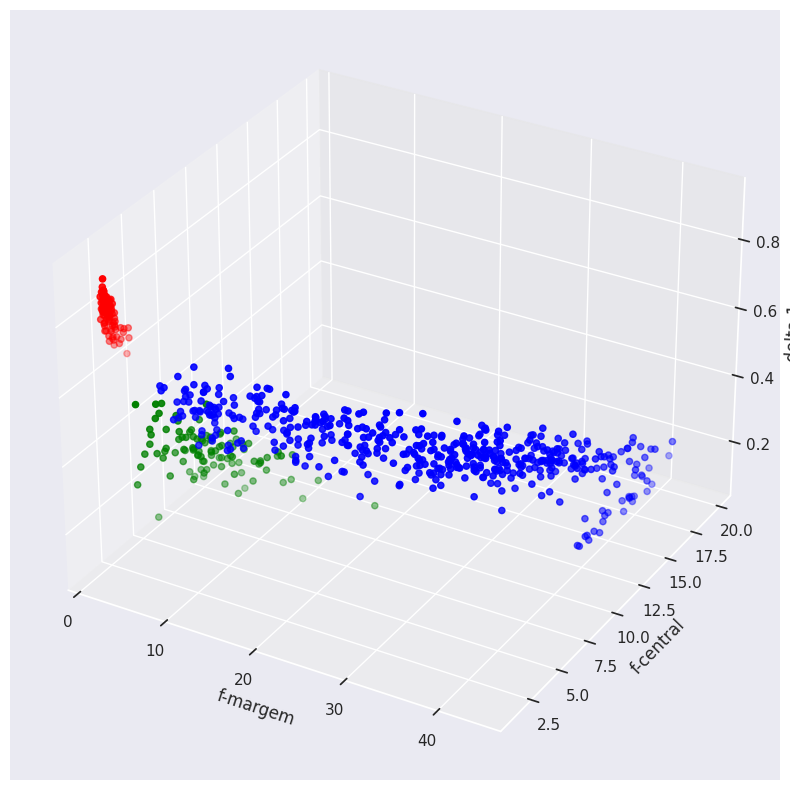

In [ ]:
# plotando as características em 3 dimensões para as caracterísitcas f-margem, f-central e delta 1
plt.figure(figsize=(15,10))

# definindo os eixos da vigilia
x_vigilia = features_vigilia[:,7]
y_vigilia = features_vigilia[:,4]
z_vigilia = features_vigilia[:,8]

# definindo os eixos do nrem4
x_nrem4 = features_stage_4[:,7]
y_nrem4 = features_stage_4[:,4]
z_nrem4 = features_stage_4[:,8]

# definindo os eixos do rem
x_rem = features_rem[:,7]
y_rem = features_rem[:,4]
z_rem = features_rem[:,8]

# definindo os nome dos eixos
ax = plt.axes(projection ="3d")
ax.set_xlabel('f-margem')
ax.set_ylabel('f-central')
ax.set_zlabel('delta 1')

ax.scatter(x_vigilia, y_vigilia, z_vigilia, color = "blue",marker='o')
ax.scatter(x_nrem4, y_nrem4, z_nrem4, color = "red",marker='o')
ax.scatter(x_rem, y_rem, z_rem, color = "green",marker='o')